# **Implementing YOLO v1 in PyTorch**

<div>
     <center><img src="./img/predictions.jpg" width="750"/> </center>
</div>

## **1. What is YOLO?**

<div>
     <center><img src="./img/paper.png" width="400"/> </center>
</div>

Developed in 2015 by Redmon et. al., YOLO (You Only Look Once) is a deep learning architecture which greatly improved the efficiency of image detection networks. The goal is simply: to detect objects appearing in an image, with their corresponding bounding boxes (see above image). Previous networks would train separately for category detection (dog, bicyle, laptop, e.g.) and bounding box detection (where an object appears in an image), going back and forth between the two to refine predictions. Redmon et. al. proposed a novel method in which bounding boxes and categories were predicted together in one pass through a single model, hence the model's name *You Only Look Once.*

#### **Why is it an important problem?**

Image recognition is an important problem with a growing field of different approches including, most recently, neural networks. Image recognition has a wide variety of uses, some of which include: [security](https://ieeexplore.ieee.org/abstract/document/8376292), [self-driving cars](https://ieeexplore.ieee.org/abstract/document/8595590), [cancer regonition](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC10377683/), and [zebra detection](https://markandrewhopkins.com/csci-381-deep-learning/). Developing fast image recognition and classification techniques is an important goal in deep learning, and it is a quickly growing industry, [expected to reach a $22.64 billion market volume by 2030](https://www.statista.com/outlook/tmo/artificial-intelligence/computer-vision/image-recognition/worldwide).

#### **Main contributions of YOLO**

YOLO's main contribution to the study of object recognition is its speed while maintaining correctness. As touched on above by calculating both the bounding boxes and the categorization in a single pass, YOLO completely outperformed the then current the state-of-the-art (Fast R-CNN). YOLO's original code is implemented entirely in C which also contributed to the immense speed up. Additionally compared to Fast R-CNN, YOLO made fewer background mistakes and was able to augment Fast R-CNN to produce an improved mAP score. Overall YOLO was the first object detection software that could run in real time with mostly correct predictions. Running at 45 frames per second with a corrisponding mAP score of 63.4, YOLO exceeds the mAP of other real time detectors by over 2 times; and compared to non-real-time detects only loses ~10 mAP.

## **2. YOLO v1 at a High Level**


YOLO, as its name suggests, predicts image categories and bounding boxes in *one pass,* greatly improving the efficiency of image classification tasks. Its architecture is relatively simple, using several convolutional layers of varying sizes, a custom loss function, and leaky ReLU. The following section describes the sources of YOLO training data, data import format, architecture, loss, and evaluation of YOLO v1.

#### **Data and Importing**

YOLO v1 pretrains its convolutional layers on the [1000-class ImageNet competition dataset](https://www.image-net.org/index.php). This training only predicts categories for full images, not bounding boxes, so the model is then trained on the [PASCAL Visual Object Classes (VOC) 2007 dataset](http://host.robots.ox.ac.uk/pascal/VOC/), which includes both category and bounding box data.

Images from both ImageNet and PASCAL VOC are first resized to 448 x 448 then fed through the CNN. The VOC training response data is formatted into $N \times S \times S \times 25$ tensors, where $N$ is the number of batches, $S$ is the grid size applied to the image, and the final dimension of length 25 takes this format:

<div>
     <center><img src="./img/in-vector.png" width="750"/> </center>
</div>

On the prediction side, we expect a slightly modified version of the above format: in this case, each cell of the $S \times S$ grid predicts a 30-length tensor, where the first 20 entries are probability predictions instead of a one-hot encoding, and the tensor predicts 2 sets of bounding boxes instead of one true box:

<div>
     <center><img src="./img/out-vector.png" width="800"/> </center>
</div>

#### **Architecture**

<div>
     <center><img src="./img/arch.png" width="1080"/> </center>
</div>

YOLO's architecture consists of 24 convolutional layers followed by 2 fully connected layers detailed above. The 1x1 convolutional layers are in place to reduce the feature space from preceding layers. This may be confusing at first as a 1x1 convolution with a stride of 1 just copies the image however; roughly speaking, different features of the input can be "learned" by different kernels of the 1x1 layer thus reducing the feature space. 

Object detection is a hard task, and at this point had not been achieved in real time. In order to simplify the task YOLO was first pre-trained to recognize images. For pre-training only the first 20 layers were trained followed by an average-pooling and fully connected layer --- these additional layer were truncated in the actual YOLO model.Using the ImageNet 2012 data the model was trained to recognize images from one of 20 catagories. After a week of training, the model achieved a top-5 accuracy of 88\% (meaning each of the network contained the correct answer in the top 5 catagories it predicted 88\% of the time).

The intuitive reasoning for YOLO's pre-training can be explained with a simple example. Say I gave you an image and asked you to find every fish in the image and draw a box around it (this is essentially the YOLO task). You could probably do it --- but say you didn't know what a fish actually looked like, the task becomes significantly harder. The same is true with YOLO, by teaching it how to recognize images in a well defined dataset of ImageNet it will help make predicting bounding boxes possible.

Up until the last layer, YOLO is just a standard CNN. In each layer of the CNN, it learns something about the pixel and the surrounding pixels in order to make its final prediction. To prevent overfitting a dropout layer with p = 0.5 is added after the first connected layer. Additionally YOLO randomly augments the data by changing the size, exposure and saturation to help with overfitting. To enforce non-linearity the leaky rectified linear unit (leaky ReLU) activation function is used with the parameter 0.1 following each layer besides the final layer. The final layer is special and uses a linear activation.

The final prediction of YOLO is where the novelty of the model comes from. The last dense layer is reshaped into a SxSxC+(B*5) tensor where S is the chosen grid size, C is the number of catagories and B is number of boxes predicted in each grid square. YOLO uses a grid size of 7x7 and 2 boxes per square to predict across 20 catagories resulting in an output of size 7x7x30. An example is seen in the image below. This approach allows both the catagory and the bounding boxes to be predicted simultaniously for fast unified detection. Working with this output is less straightforward then something like a series of probability weights or a single value; however YOLO provides a unique loss function to handle this. 



<div>
     <center><img src="./img/grid.png" width="750"/> </center>
</div>

#### **Loss**

YOLO v1 implements a custom loss function, described in their paper in the following equation:

<div>
     <center><img src="./img/loss.png" width="900"/> </center>
</div>

This may look overwhelming at first, but it's not overly complicated. The loss function takes the SSE across the predicted $(x,y)$ box midpoint, $(h,w)$ box dimensions, the predicted probability of an object in the box, and the set of $c_i$ category probabilities. The first and second line compute SSE loss for the midpoint coordinates and dimensions, the next two lines compute the SSE loss for object confidence (whether an object appears in the box), and the last line computes the SSE for category probability predictions.

**Some important symbols to note:**

&nbsp;&nbsp;&nbsp;&nbsp; $𝟙_{i}^{\textrm{obj}}$ indicates whether an object appears in cell $i$

&nbsp;&nbsp;&nbsp;&nbsp; $𝟙_{ij}^{\textrm{obj}}$ indicates whether the $j^{\textrm{th}}$ bounding box predictor in cell $i$ is "responsible" for that prediction (highest intersection over union, or IOU)

&nbsp;&nbsp;&nbsp;&nbsp; $C_i$ indicates whether box $i$ contains an object in the training data

&nbsp;&nbsp;&nbsp;&nbsp; $\hat{C}_i$ is the predicted probability that an object appears in box $i$

&nbsp;&nbsp;&nbsp;&nbsp; $\lambda_{\textrm{coord}}$ is a learning parameter set to 5

&nbsp;&nbsp;&nbsp;&nbsp; $\lambda_{\textrm{noobj}}$ is a learning parameter set to 0.5

#### **Evaluation**

There are two main metrics that YOLO evaluates itself on: speed and mean average precision (mAP). Since YOLO is a real time detection tool its speed in measured by how many image frames can it predict per second (fps). This metric is important because this is the fps it can accurately translate video at. YOLO is able to translate at 45fps, significantly faster than any detector with similar mAP scores. For reference the human eye on average can only see between 30fps and 60fps, thus 45fps is plenty fast for real time translation. Fast YOLO, a smaller version translates at 155fps for a moderate hit to mAP.

The second evaluation metric is mAP. Essentially, mAP is a measure of correctness of the prediction. Generally speaking mAP refers to the area under the precision-recall curve. To understand this first we need to understand precision and recall. Precision measures of all positive predicts the model made how many were correct, i.e. $\frac{\text{correct positive predictions}}{\text{all positive predictions}}$ where in our case a "positive prediction" refers to predicting an object. Recall measures of all predictions how many were positive and correct i.e. $\frac{\text{correct positive predictions}}{\text{all predictions}}$. Each of these metrics on there own are not particularly useful as predicting positive for all instances gets a perfect recall and predicting a small subset of easy to predict images gets perfect precision. However, if we can encapsulate both metrics into one then we can optimize it. We do this using the precison-recall curve which plots precison as a function of recall. To evaluate then all we have to do is take the integral of the precison-recall curve. 

For object detection the input to the recall and loss functions is whether or not the box is correct. To determine that we measure the Intersection Over Union (IOU) between the predicted boxes and the ground truth boxes in the image. If the IOU is over some threshold we declare that the box is correct otherwise we declare that it is incorrect. The threshold in this case is dependent on how "good" we want the boxes to be. The YOLO paper doesn't say what threshold they use, but other implementations use 80\%.

For its speed YOLO significantly outperforms the state-of-the-art mAP scores only losing to Fast R-CNN, and Faster R-CNN VGG-16 that run at 0.5 and 7fps respectively. 

Below we provide a table that compares the mAP and fps of different object detectors.  

<div>
     <center><img src="./img/eval.png" width="400"/> </center>
</div>



#### **Evaluation**

There are two main metrics that YOLO evaluates itself on: speed and mean average precision (mAP). Since YOLO is a real time detection tool its speed in measured by how many image frames can it predict per second (fps). This metric is important because this is the fps it can accurately translate video at. YOLO is able to translate at 45fps, significantly faster than any detector with similar mAP scores. For reference the human eye on average can only see between 30fps and 60fps, thus 45fps is plenty fast for real time translation. Fast YOLO, a smaller version translates at 155fps for a moderate hit to mAP.

The second evaluation metric is mAP. Essentially, mAP is a measure of correctness of the prediction. Generally speaking mAP refers to the area under the precision-recall curve. To understand this first we need to understand precision and recall. Precision measures of all positive predicts the model made how many were correct, i.e.

$$\frac{\text{correct positive predictions}}{\text{all positive predictions}}$$

where in our case a "positive prediction" refers to predicting an object. Recall measures of all predictions how many were positive and correct i.e.

$$\frac{\text{correct positive predictions}}{\text{all predictions}}$$

Each of these metrics on there own are not particularly useful as predicting positive for all instances gets a perfect recall and predicting a small subset of easy to predict images gets perfect precision. However, if we can encapsulate both metrics into one then we can optimize it. We do this using the precison-recall curve which plots precison as a function of recall. To evaluate then all we have to do is take the integral of the precison-recall curve. 

For object detection the input to the recall and loss functions is whether or not the box is correct. To determine that we measure the Intersection Over Union (IOU) between the predicted boxes and the ground truth boxes in the image. If the IOU is over some threshold we declare that the box is correct otherwise we declare that it is incorrect. The threshold in this case is dependent on how "good" we want the boxes to be. The YOLO paper doesn't say what threshold they use, but other implementations use 80\%.

For its speed YOLO significantly outperforms the state-of-the-art mAP scores only losing to Fast R-CNN, and Faster R-CNN VGG-16 that run at 0.5 and 7fps respectively. 

Below we provide a table that compares the mAP and fps of different object detectors.  

<div>
     <center><img src="./img/eval.png" width="400"/> </center>
</div>
 



## **3. Our Simplified Implementation**

We implemented a very basic version of YOLO called *YOLO-Basic* that can perform a simpler task than the original YOLO due to computing and time constraints. 

In order to speed up the YOLO training pipeline we made three significant changes. Firstly, we used synthetically genereated images of 5 different shapes (X, Circle, Square, Rectangle, Star. This helped remove background noise as shapes are generated on a plain white background allowing for easier recognition. It also reduced the dimensionality of the output because there were less catagories to predict. Secondly we reduce the size of the final output grid from 7x7 to 3x3 to greatly reduce the amount of predictions the model makes each minibatch. To that end we also have each grid cell only predict a single bounding box. These two changes combined greatly simplify our output as we have gone from a 7x7x(20 + 2\*5) = 1470 parameter output shape to a 3x3x(5 + 1\*5) = 90 parameter output shape. This reduction of dimentionality allows for out last significant change which was simplifying the network. We removed several convolutional layers and greatly reduced the kernel size at each layer to 32, down from some kernel sizes over 1000. Lastly, we provide the images as 112x112 images to simplify the input; without background noise sharper images are not needed for identification.

Below we explain the simplification we did in more detail and provide a easily runnable set of code cells to run *YOLO-Basic* from start to finish. These code cells mostly import functions from other python files that we wrote so if you are concerned with implementation details you should view the other .py files in this repo.

In [1]:
### IMPORTS 

import torch
import os
import random
from IPython.display import HTML

In [2]:
### CONSTANTS

DATA_DIR = "DEMO"
TRAIN_SIZE = 100
TEST_SIZE = 10
PRETRAINED_PARAMS = "models/demo_pretrain.pt"
YOLO_PARAMS = "models/demo_yolo.pt"
CATAGORIES = ['O', 'Pent', 'Square', 'Star', 'X']

#### **Data and Generation**

As noted in the introduction we used synthetically generated data to train and test our *YOLO-Basic* model. To generate the images we used the python PIL library. We wrote 5 different functions that each generated a shape of random size in a random position on the screen. Each shape had an associated bounding box that completely surrounded the shape plus a small adjustment factor. Shapes were generated to be of reasonable size (between 1/8 and 1/2 of the image) and such that the entire shape was contained in the frame of the image. Example images can be seen after generating the data by running the corrisponding cell. 

To simulate the training proceedure of YOLO, the pretraining set is a different set of images than the YOLO training set. The images are generated as detailed above with 1000 images of each shape for training and 100 images of each shape for validation. These images were no longer used after the pretraining was completed.

To generate the YOLO training and testing data, 10,000 images of each shape were generated to use as a training set for a total of 50,000 training images; 100 images of each shape were generated as a validation set to monitor the accuracy. With each image that was created an entry was also created into the data.json file for a given data directory. Eeach entry contains the shape label, the path to the image file, the partition (train / test) and the bounding box. The data loader can then use this json file to read in the data for training and testing. A preview of this json can be seen by running the corrisponding cell below.

Note: while multiple shape generation is possible given our functions we only generated images with a single shape for training and testing for simplicity and time sake; however in theory *YOLO-Basic* could still recognize mulitple shapes in a single image.  

To generate and visualize the data run the cells below!


In [3]:
# DATA GENERATION
from generate_data import generate_data

generate_data(DATA_DIR, TRAIN_SIZE, TEST_SIZE)


ERROR: Data Directory DEMO already exists
if you would like to continue run rm -r DEMO in your terminal


In [3]:
### DISPLAY GENERATED IMAGES

num = random.randint(0, TRAIN_SIZE)
image_paths = [os.path.join(DATA_DIR, "train", x, str(num) + ".png") for x in os.listdir(os.path.join(DATA_DIR, "train"))]

images_html = ''.join(f'<img src="{path}" style="width: 18%; margin: 10px; float: left;" />' for path in image_paths)

html_content = f'<div style="width: 100%;">{images_html}</div>'

HTML(html_content)

In [4]:
### DISPLAY JSON DATA

# json data stores ground truth data associated with the images.
def display_file_head(file_path, num_lines=19):
    with open(file_path, 'r') as file:
        for _ in range(num_lines):
            line = file.readline()
            if not line:
                break
            print(line.strip())

file_path = os.path.join(DATA_DIR, "data.json")
display_file_head(file_path)

[
{
"label": "X",
"filename": "DEMO/train/X/0.png",
"partition": "train",
"box": "1,0.58875,0.80875,0.1025,0.1025"
},
{
"label": "X",
"filename": "DEMO/train/X/1.png",
"partition": "train",
"box": "1,0.78875,0.34625,0.2775,0.2775"
},
{
"label": "X",
"filename": "DEMO/train/X/2.png",
"partition": "train",
"box": "1,0.7325,0.63,0.105,0.105"
},


#### **Loss**

We modify the YOLO v1 loss to fit our simplified model. Namely, we reduce the number of category predictions from 20 (from the VOC dataset) to 5 (shapes), and we reduce from 2 bounding boxes to 1, and we reduce our grid size to 3. We define a custom loss function called `yolo_loss`, which takes in an $S$ value (grid size), a $B$ value (number of box predictions), and a $C$ value (number of categories). Corresponding to our modificatons, we set $S = 3$, $B = 1$, and $C = 5$.

We borrow some code from [https://github.com/aladdinpersson](https://github.com/aladdinpersson) to implement the more tricky torch operations in calculating this loss. The full loss function, broken down into its constituent parts, can be found in `loss.py`.

#### **Architecture and Training**

Overall, as mentioned in the intro, to fit our computational and time constraints, we greatly reduced the complexity of the models. We reduced the number of pretraining convolutional layers from 20 to 8 and the number of kernel all down to 32. We use the same amount of max pooling layer and layers with stride > 1 in order to reduce to the same grid size; however we add one extra maxpool layer at the end of the pretrain model to reduce what will become the grid size in yolo training to 3x3. 

For yolo training we add 4 new untrained layers as the paper suggests; however our total is sill 12 layers vs 24 layers. Furthermore, as in pretraining the number of kernels are all 32 down from 1024. 

For both pretraining and yolo training we use Leaky ReLU as our activation function with parameter 0.1 as described in the paper. We also implement a dropout layer with p = 0.5 between our fully connected layers as described by the paper. 

For training we used minibatch gradient decent with a batch size of 32 for both pretraining and yolo training. Pretraining was able to quickly converge to perfect accuracy on both the training and test set and stopped training early around 5 epochs. YOLO training ran for [TODO] epochs before it converged. We used the ADAM optimizer for our decent with learning rate of 0.001 and the default ADAM parameters.

To build and train the model run the cells below!

In [4]:
### creating the pretraining model
from specs import pretrain_specs
from model import build_net

print("Pretrain Layers:")
pretrain_arch = build_net(pretrain_specs)
print(pretrain_arch)

Pretrain Layers:
Sequential(
  (conv0): ConvLayer()
  (l_relu1): Leaky_ReLU()
  (conv2): ConvLayer()
  (l_relu3): Leaky_ReLU()
  (conv4): ConvLayer()
  (l_relu5): Leaky_ReLU()
  (conv6): ConvLayer()
  (l_relu7): Leaky_ReLU()
  (pool8): MaxPool()
  (conv9): ConvLayer()
  (l_relu10): Leaky_ReLU()
  (conv11): ConvLayer()
  (l_relu12): Leaky_ReLU()
  (pool13): MaxPool()
  (conv14): ConvLayer()
  (l_relu15): Leaky_ReLU()
  (conv16): ConvLayer()
  (l_relu17): Leaky_ReLU()
  (pool18): MaxPool()
  (flatten19): Flatten()
  (dense20): Dense()
  (l_relu21): Leaky_ReLU()
  (drop22): Dropout()
  (dense23): Dense()
)


In [ ]:
### training the pretrained model
from train import pretrain

pretrain(os.path.join(DATA_DIR, "data.json"), PRETRAINED_PARAMS, None)


In [5]:
### Build YOLO model with pretrained parameters
from specs import pretrain_specs, additional_yolo_specs
from model import build_yolo_net

print("YOLO Layers:")
yolo_arch = build_yolo_net(pretrain_specs, additional_yolo_specs, PRETRAINED_PARAMS)
print(yolo_arch)

YOLO Layers:
Sequential(
  (0): ConvLayer()
  (1): Leaky_ReLU()
  (2): ConvLayer()
  (3): Leaky_ReLU()
  (4): ConvLayer()
  (5): Leaky_ReLU()
  (6): ConvLayer()
  (7): Leaky_ReLU()
  (8): MaxPool()
  (9): ConvLayer()
  (10): Leaky_ReLU()
  (11): ConvLayer()
  (12): Leaky_ReLU()
  (13): MaxPool()
  (14): ConvLayer()
  (15): Leaky_ReLU()
  (16): ConvLayer()
  (17): Leaky_ReLU()
  (18): MaxPool()
  (19): ConvLayer()
  (20): Leaky_ReLU()
  (21): ConvLayer()
  (22): Leaky_ReLU()
  (23): ConvLayer()
  (24): Leaky_ReLU()
  (25): ConvLayer()
  (26): Leaky_ReLU()
  (27): Flatten()
  (28): Dense()
  (29): Leaky_ReLU()
  (30): Dropout()
  (31): Dense()
)


In [ ]:
from train import train

train(os.path.join(DATA_DIR, "data.json"), YOLO_PARAMS, None)

In [6]:
### Get trained YOLO model

yolo_model = yolo_arch
yolo_model.load_state_dict(torch.load(YOLO_PARAMS))


<All keys matched successfully>

Compute Time: 0.020257949829101562
Esimated fps: 2961.8002071368046
Confidence: 1.7262946367263794
Prediction: O


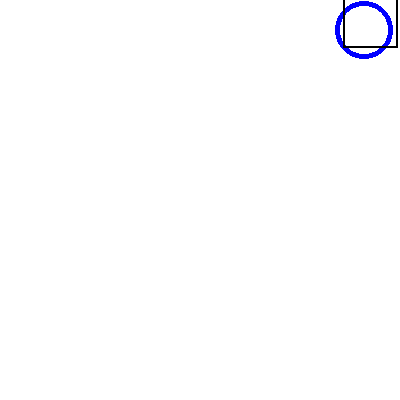

In [29]:
### PREDICT

from boxey import id

IMAGE_TO_PREDICT = f'{CATAGORIES[random.randint(0,4)]}/{random.randint(0,9)}.png'

predicted = id(os.path.join(DATA_DIR, "test"), IMAGE_TO_PREDICT, yolo_model, CATAGORIES, jupyter=True)

display(predicted)

#### **Evaluation**

For the pretraining data (an image recognition task) we used accuracy as our evaluation metric. For each element in our validation set we checked if the model predicted the right catagory and divide by the number of elements in our validation set. 

For the yolo proceedure evaluate, as described above is much more complicated. Due to time constraints we did not implement the mAP metric as described above; however, since this is a task in object recognition, it is possible to emperically evaluate our model. Furthermore, since we are minimizing the loss not the evaluation it doesn't effect our models ability to train. We would love to implement mAP as future work. 

## **4. Conclusion**

YOLO is a powerful image recognition and classification architecture, which sent waves through the deep learning community for its impressive speed and accuracy. The model has undergone several improvements, and it seems that the Vision AI company Ultralytics bought the architecture at some point; three weeks ago they released YOLO v.8.2.0, which can be found implemented in PyTorch [on their GitHub repository](https://github.com/ultralytics/ultralytics). Although many improvements have been made to the architecture and methodology, the overall structure still largely resembles YOLO v1.

In this notebook, we have built a modified version of YOLO v1 which was able to train on much a less powerful machine in much less time than the full YOLO architecture. Along the way, we had to make certain sacrifices to pare down the original implementation, and doing so has been a valuable learning experience. We hope you have enjoyed this guide, and that you have found this learning as valuable as we have. The field of image recognition has been greatly changed by the introduction of neural networks and the development of YOLO, and there are sure to be many interesting developments in the field in the years to come.